In [1]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os

In [2]:
class CovarianceCalculator(object):
    def __init__(self, mask, nhits, binning):
        self.b = binning
        self.mask = mask
        self.npix = len(mask)
        self.nside = hp.npix2nside(self.npix)
        self.lmax = 3*self.nside-1
        self.n_ell = self.b.get_n_bands()
        self.ls = np.arange(self.lmax+1)
        self.mask_alm = None
        self.noise_mcm = None
        self.w = None
        self.fields = None
        self.cws = None

        self.sigma = np.zeros_like(mask)
        good = nhits > 0
        self.sigma[good] = 1/np.sqrt(nhits[good])
        self.mask_noise = self.mask*self.sigma
        self.fsky = np.mean(self.mask**2)
        self.rescale_sn = np.mean((self.sigma*self.mask)**2)/self.fsky

    def get_field(self, kind):
        if self.fields is None:
            fp = nmt.NmtField(self.mask, None, spin=2,
                              purify_b=True, purify_e=True)
            fs = nmt.NmtField(self.mask, None, spin=2)
            fn = nmt.NmtField(self.mask_noise/np.sqrt(self.rescale_sn),
                              None, spin=2)
            self.fields = {'p': fp, 's': fs, 'n': fn}
        return self.fields[kind]

    def get_w(self):
        if self.w is None:
            fp = self.get_field('p')
            self.w = nmt.NmtWorkspace(fp, fp, self.b)
        return self.w

    def get_cw(self, kind):
        if self.cws is None:
            w = self.get_w()
            fs = self.get_field('s')
            fn = self.get_field('n')
            fp = self.get_field('p')
            cw_ss = nmt.NmtCovarianceWorkspace.from_fields(fs, fs)
            cw_sn = nmt.NmtCovarianceWorkspace.from_fields(fs, fn, fs, fn)
            cw_nn = nmt.NmtCovarianceWorkspace.from_fields(fn, fn)
            self.cws = {'ss': cw_ss, 'sn': cw_sn, 'nn': cw_nn}
        return self.cws[kind]
    
    def get_mask_alm(self):
        if self.mask_alm is None:
            self.mask_alm = hp.map2alm(mask)
        return self.mask_alm

    def get_beta(self, s, inv=False):
        beta = np.ones_like(self.ls)
        for n in range(1, 2*s+1):
            beta *= self.ls-s+n
    
        bad_ell = beta <= 0
        beta[bad_ell] = 1000
        beta = np.sqrt(beta)
        if not inv:
            beta = 1/beta
        beta[bad_ell] = 0
        return beta

    def spin_mask(self, spin):
        mask_alm = self.get_mask_alm()
        beta = self.get_beta(spin, inv=True)
        mask_alm = -hp.almxfl(mask_alm, beta)
        return hp.alm2map_spin([mask_alm, 0*mask_alm],
                               self.nside, spin,
                               self.lmax)

    def get_noise_mcm(self):
        if self.noise_mcm is None:
            mask0 = self.mask
            mask1 = np.array(self.spin_mask(1))
            mask2 = np.array(self.spin_mask(2))
            elm_0 = -hp.map2alm(mask0*self.sigma)
            blm_0 = 0*elm_0
            elm_1, blm_1 = hp.map2alm_spin(self.sigma*mask1, spin=1,
                                           lmax=self.lmax, mmax=self.lmax)
            elm_2, blm_2 = hp.map2alm_spin(self.sigma*mask2, spin=2,
                                           lmax=self.lmax, mmax=self.lmax)
            alms = np.array([[elm_0, blm_0],
                             [elm_1, blm_1],
                             [elm_2, blm_2]])
            cls_mask = np.array([[hp.alm2cl(e1, e2) + hp.alm2cl(b1, b2)
                                  for e2, b2 in alms]
                                 for e1, b1 in alms])
            mcms = np.array([[nmt.get_general_coupling_matrix(cls_mask[i1, i2],
                                                              2, 2, 2-i1, 2-i2)
                              for i1 in range(3)]
                             for i2 in range(3)])
        
            binoms = np.array([1., 2., 1.])
            beta_2 = self.get_beta(2)
            self.noise_mcm = np.zeros([self.lmax+1, self.lmax+1])
            for n1 in range(3):
                ibeta_n1 = self.get_beta(n1, inv=True)
                binom_n1 = binoms[n1]
                for n2 in range(3):
                    ibeta_n2 = self.get_beta(n2, inv=True)
                    binom_n2 = binoms[n2]
                    prefac = binom_n1 * binom_n2 * beta_2**2 * ibeta_n1 * ibeta_n2
                    self.noise_mcm += prefac[:, None]*mcms[2-n1, 2-n2]
        return self.noise_mcm

    def get_pnl(self, nl):
        mcm = self.get_noise_mcm()
        pnl = np.dot(mcm, nl)
        pnl = np.array([pnl, 0*pnl, 0*pnl, pnl])
        return pnl


    def get_covar(self, cl_matrix, nl_vector, i1, i2, j1, j2):
        w = self.get_w()
        cl0 = np.zeros(self.lmax+1)
        pcl0 = np.array([cl0, cl0, cl0, cl0])
        fsky = self.fsky

        # Get signal covariance
        cl = cl_matrix[i1, j1]
        psl_i1_j1 = w.couple_cell(np.array([cl0, cl0, cl0, cl]))/fsky
        cl = cl_matrix[i1, j2]
        psl_i1_j2 = w.couple_cell(np.array([cl0, cl0, cl0, cl]))/fsky
        cl = cl_matrix[i2, j1]
        psl_i2_j1 = w.couple_cell(np.array([cl0, cl0, cl0, cl]))/fsky
        cl = cl_matrix[i2, j2]
        psl_i2_j2 = w.couple_cell(np.array([cl0, cl0, cl0, cl]))/fsky
        cw_ss = self.get_cw('ss')
        cov_ss = nmt.gaussian_covariance(cw_ss, 2, 2, 2, 2,
                                         psl_i1_j1, psl_i1_j1,
                                         psl_i2_j1, psl_i2_j2,
                                         w)
        cov0 = cov_ss*0

        # Get noise covariance
        cw_nn = self.get_cw('nn')
        cov_nn = cov0.copy()
        pnl_i1 = self.get_pnl(nl_vector[i1])/fsky
        pnl_i2 = self.get_pnl(nl_vector[i2])/fsky
        if (i1 == j1) and (i2 == j2):
            cov_nn += nmt.gaussian_covariance(cw_nn, 2, 2, 2, 2,
                                              pnl_i1, pcl0, pcl0, pnl_i2,
                                              w)
        if (i1 == j2) and (i2 == j1):
            cov_nn += nmt.gaussian_covariance(cw_nn, 2, 2, 2, 2,
                                              pnl_i1, pcl0, pcl0, pnl_i2,
                                              w)

        # Get signal-noise covariance
        cw_sn = self.get_cw('sn')
        cov_sn = cov0.copy()
        if i1 == j1:
            cov_sn += nmt.gaussian_covariance(cw_sn, 2, 2, 2, 2,
                                              psl_i2_j2, pcl0, pcl0, pnl_i1,
                                              w)
        if i2 == j2:
            cov_sn += nmt.gaussian_covariance(cw_sn, 2, 2, 2, 2,
                                              psl_i1_j1, pcl0, pcl0, pnl_i2,
                                              w)
        if i1 == j2:
            cov_sn += nmt.gaussian_covariance(cw_sn, 2, 2, 2, 2,
                                              psl_i2_j1, pcl0, pcl0, pnl_i1,
                                              w)
        if i2 == j1:
            cov_sn += nmt.gaussian_covariance(cw_sn, 2, 2, 2, 2,
                                              psl_i1_j2, pcl0, pcl0, pnl_i2,
                                              w)

        cov = cov_ss + cov_sn + cov_nn
        cov = cov.reshape([self.n_ell, 4, self.n_ell, 4])
        cov = cov[:, 3, :, 3]
        return cov

In [25]:
noi_factor = 1.0
sig_factor = 1.0
nsims = 100
nside = 256
iband = 2
color = 'red'
mask = hp.ud_grade(hp.read_map("data/mask_apodized.fits"), nside_out=nside)
nhits = hp.read_map(f"data/nhits_ns{nside}.fits.gz")
b = nmt.NmtBin.from_nside_linear(nside, nlb=10)

In [26]:
os.system('mkdir -p data/cls')
cls = []
for i in range(nsims):
    seed = 1000 + i
    predir = 'data/cls'
    fname = f'{predir}/cls_sig_{seed}.npz'
    cl_ss = np.load(fname)['cl']
    fname = f'{predir}/cls_signoi_{color}_band{iband}_{seed}.npz'
    cl_sn = np.load(fname)['cl']
    fname = f'{predir}/cls_noi_{color}_band{iband}_{seed}.npz'
    cl_nn = np.load(fname)['cl']
    cl = sig_factor**2*cl_ss + 2*sig_factor*noi_factor*cl_sn + noi_factor**2*cl_nn
    cls.append(cl)
cls = np.array(cls)

In [27]:
def read_cls(lmax):
    d = np.load("data/nls.npz")
    ls = d['ls']
    if color == 'white':
        nl = d['nls_white'][iband]
    else:
        nl = d['nls'][iband]
    nl[:2] = 0

    ll, _, dlee, dlbb, _ = np.loadtxt("data/camb_lens_nobb.dat", unpack=True)
    dl2cl = 2*np.pi/(ll*(ll+1))
    clbb = np.zeros(lmax+1); clbb[2:] = (dl2cl*dlbb)[1:lmax]
    return ls, nl, clbb

ls, nl, clbb = read_cls(3*nside-1)
nl *= noi_factor**2
clbb *= sig_factor**2
nls_th = np.array([nl])
cls_th = np.array([[clbb]])

In [28]:
cc = CovarianceCalculator(mask, nhits, b)

In [29]:
cov_th = cc.get_covar(cls_th, nls_th, 0, 0, 0, 0)

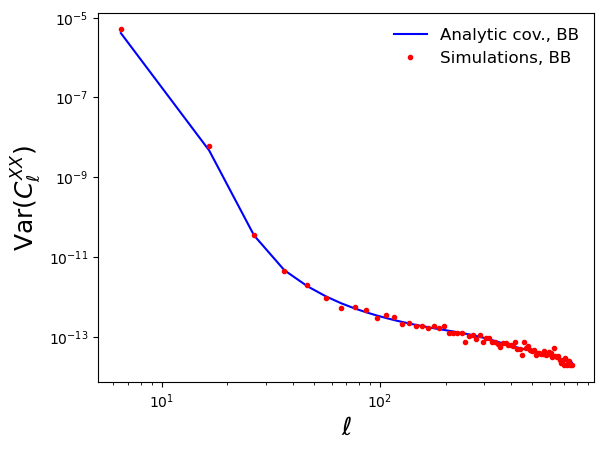

In [30]:
plt.figure()
leff = b.get_effective_ells()
plt.plot(leff, np.diag(cov_th), 'b-', label='Analytic cov., BB')
plt.plot(leff, np.std(cls[:, 3, :], axis=0)**2, 'r.', label='Simulations, BB')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'${\rm Var}(C^{XX}_\ell)$', fontsize=18)
plt.legend(frameon=False, fontsize=12)